In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Kaggle/input/tutors/train.csv')

X = df.drop('mean_exam_points', axis=1)
y = df[['mean_exam_points']]

X_final = pd.read_csv('/Kaggle/input/tutors/test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

#X.set_index('Id', inplace=True)
#X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 10000
Строк в тесте 10000


In [3]:
df_num_features = df.select_dtypes(include='float64')
df_num_features.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points'],
      dtype='object')

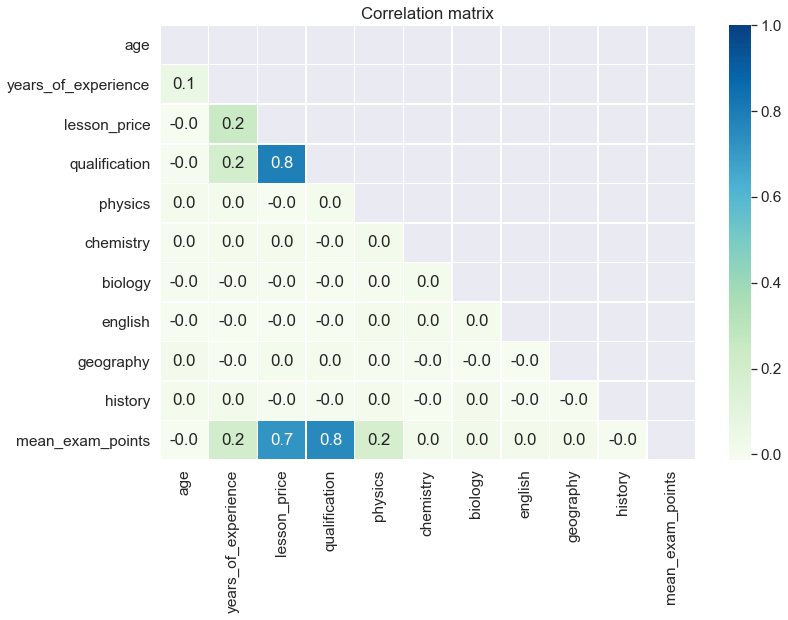

In [4]:

num_features = pd.DataFrame(df_num_features)
corr = num_features.corr()
plt.figure(figsize = (12, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

Как мы видим, большое значение корелляции полученных баллов у значений lesson_price, qualification, кроме того, небольшую корелляцию имеют графы years_of_experience и physics. Остальные предметы, а также возраст, значения практически не имеют. 

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [6]:
X.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
X.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dict(X['qualification'].value_counts())

{1.0: 4884, 2.0: 3087, 3.0: 1979, 4.0: 50}

In [9]:
dict(X['years_of_experience'].value_counts())

{0.0: 2785,
 2.0: 1804,
 1.0: 1757,
 3.0: 1572,
 4.0: 1122,
 5.0: 584,
 6.0: 282,
 7.0: 70,
 8.0: 20,
 9.0: 3,
 10.0: 1}

In [10]:
dict(X['physics'].value_counts())

{0.0: 6250, 1.0: 3750}

In [11]:
class Featuring:
    '''Класс - добавление параметров'''
    
    def physics_qualification(self, df):
        '''квалификация по физике'''
        
        df = df[:]
        
        df['physics_qualification'] = df['physics']*df['qualification']
        
        return df
    
    def price_level(self, df):
        '''отношение цены к средней по выборке'''
        
        df = df[:]
        median_price = df['lesson_price'].mean()
        df['price_level'] = df['lesson_price'] - median_price
        
        return df

    def unimportant_drop(self, df):
        '''избавление от ни на что не влияющих показателей'''
        
        df = df.drop(['chemistry', 'biology', 'english', 'geography', 'history'], axis=1)

        return df

    
    def physics_qualified_years(self, df):
        '''сумма годов опыта, уровня в физике и квалификации'''
        
        df = df[:]
        df['physics_qualified_years'] = df['physics']+df['years_of_experience']+df['qualification']

        return df  
    
    def pipline(self, df):
        '''последовательное выполнение'''
        
        df = df[:]
        
        df = self.physics_qualification(df)
        df = self.price_level(df)
        df = self.unimportant_drop(df)
        df = self.physics_qualified_years(df)

        return df
    

In [12]:
featuring = Featuring()

In [13]:
df = featuring.pipline(df)
df.head()

C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Id,age,years_of_experience,lesson_price,qualification,physics,mean_exam_points,physics_qualification,price_level,qualified_years,physics_qualified_years
0,0,40.0,0.0,1400.0,1.0,1.0,63.0,1.0,-299.105,1.0,2.0
1,1,48.0,4.0,2850.0,3.0,1.0,86.0,3.0,1150.895,7.0,8.0
2,2,39.0,0.0,1200.0,1.0,0.0,53.0,0.0,-499.105,1.0,1.0
3,3,46.0,5.0,1400.0,1.0,0.0,56.0,0.0,-299.105,6.0,6.0
4,4,43.0,1.0,1500.0,1.0,0.0,59.0,0.0,-199.105,2.0,2.0


In [14]:
df_num_features = df.select_dtypes(include='float64')
df_num_features.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'mean_exam_points', 'physics_qualification', 'price_level',
       'qualified_years', 'physics_qualified_years'],
      dtype='object')

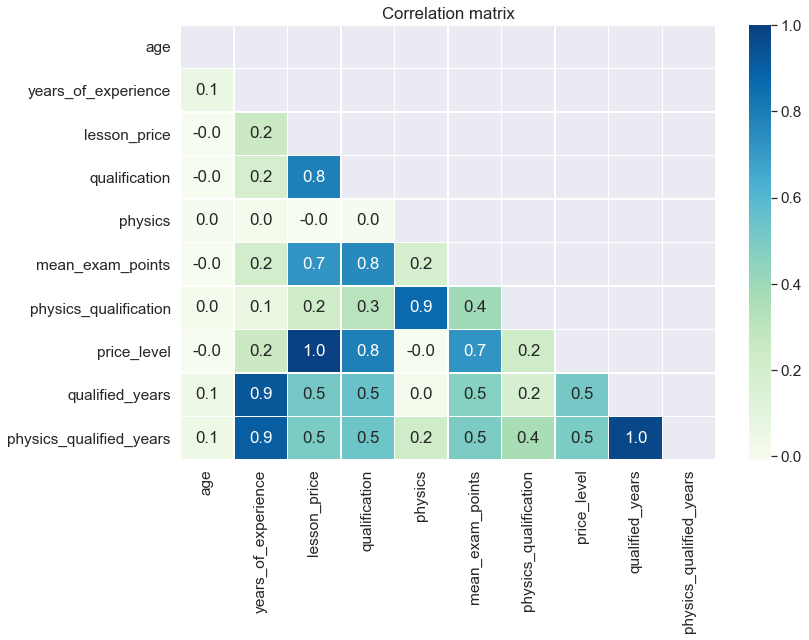

In [15]:
num_features = pd.DataFrame(df_num_features)
corr = num_features.corr()
plt.figure(figsize = (12, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

In [16]:
X = df.drop('mean_exam_points', axis=1)
y = df[['mean_exam_points']]


In [17]:
X = np.array(df.drop('mean_exam_points', axis=1))
y = np.array(df[['mean_exam_points']]).T[0]

In [18]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [19]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction

In [20]:
# И класс дерева
class Tree:

  def __init__(self, max_depth=50):
    self.max_depth = max_depth
    self.tree = None

  # Расчёт дисперсии значений
  def dispersion(self, labels):
    return np.std(labels)

  # Расчет качества

  def quality(self, left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)

    # Разбиение датасета в узле

  def split(self, data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения

  def find_best_split(self, data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_dispersion = self.dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
      # будем проверять только уникальные значения признака, исключая повторения
      t_values = np.unique([row[index] for row in data])
      
      for t in t_values:
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов
        if len(true_data) < min_leaf or len(false_data) < min_leaf:
          continue
        
        current_quality = self.quality(true_labels, false_labels, current_dispersion)
        
        #  выбираем порог, на котором получается максимальный прирост качества
        if current_quality > best_quality:
          best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

  def build_tree(self, data, labels, tree_depth, max_depth):

    quality, t, index = self.find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
      return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
      return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = self.build_tree(true_data, true_labels, tree_depth, max_depth)
    false_branch = self.build_tree(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

  def predict_object(self, obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
      answer = node.prediction
      return answer

    if obj[node.index] <= node.t:
      return self.predict_object(obj, node.true_branch)
    else:
      return self.predict_object(obj, node.false_branch)

  def predict(self, data):
    
    val = []
    for obj in data:
      prediction = self.predict_object(obj, self.tree)
      val.append(prediction)
    return val

  def fit(self, data, labels):
    self.tree = self.build_tree(data, labels, 0, self.max_depth)
    return self

In [21]:
class GradientBoosting:
    
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []

    def bias(self, y, z):
        return (y - z)

    def fit(self, X_train, y_train):
    
    # Деревья будем записывать в список
        trees = []
    
        for i in range(self.n_trees):
            tree = Tree(max_depth=self.max_depth)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                bias = self.bias(y_train, target)
                tree.fit(X_train, bias)

            self.trees.append(tree)
        
        return self

    def predict(self, X):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [22]:
def r_2(y_pred, y_true):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0,
                                                          dtype=np.float64)
    return 1 - (numerator / denominator)

In [23]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [24]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.5

In [25]:
gb = GradientBoosting(n_trees, max_depth, coefs, eta)
gb.fit(train_data, train_labels)
train_answers = gb.predict(train_data)
test_answers = gb.predict(test_data)

In [26]:
r_2(train_answers, train_labels)

0.7966045959750456

In [27]:
r_2(test_answers, test_labels)

0.7738369387344389

In [28]:
gb_final = GradientBoosting(n_trees, max_depth, coefs, eta)
gb_final.fit(X, y)

In [29]:
X_test = featuring.pipline(X_final)
X_test.head()

C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vladi\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Id,age,years_of_experience,lesson_price,qualification,physics,physics_qualification,price_level,qualified_years,physics_qualified_years
0,10000,46.0,3.0,1050.0,1.0,0.0,0.0,-647.095,4.0,4.0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,152.905,5.0,5.0
2,10002,52.0,1.0,1550.0,1.0,1.0,1.0,-147.095,2.0,3.0
3,10003,57.0,6.0,2900.0,3.0,1.0,3.0,1202.905,9.0,10.0
4,10004,44.0,4.0,3150.0,3.0,1.0,3.0,1452.905,7.0,8.0


In [30]:
X_test = np.array(X_test)


print(X_test.shape)


#X = np.array(df.drop('mean_exam_points', axis=1))
#y = np.array(df[['mean_exam_points']]).T[0]

(10000, 10)


In [31]:
test_pred = gb_final.predict(X_test)


In [32]:
submissions = pd.concat([preds_final, pd.Series(test_pred)], axis=1)
submissions = submissions.rename(columns={0: 'mean_exam_points'})

In [33]:
submissions.to_csv('VKaldin_predictions_17.csv',index=None)